In this notebook, I load a dataset using Pandas library and then apply the following algorithms (KNN, Decision Tree, SVM, and Logistic Regression), and find the best one for this specific dataset by accuracy evaluation methods (Jaccard, F1-score, LogLoss).

Lets first load all required libraries:


In [260]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [261]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-03-29 12:23:36--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-03-29 12:23:37 (138 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [262]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [263]:
df.shape

(346, 10)

### Convert to date time object


In [264]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [265]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time, while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [266]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

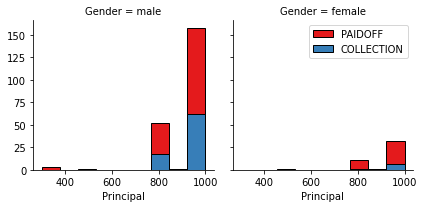

In [267]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

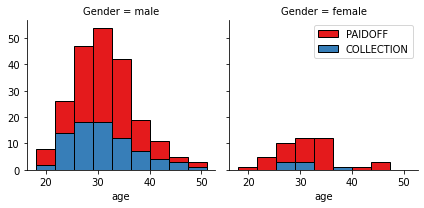

In [268]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing: Feature selection/extraction


### Lets look at the day of the week people get the loan


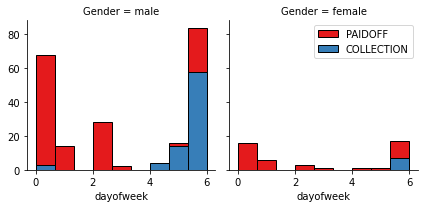

In [269]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [270]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [271]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [272]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One-Hot Encoding

#### How about Education?


In [273]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [274]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [275]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [276]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [277]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [278]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, I use the training set to build an accurate model. Then I use the test set to report the accuracy of the model
I use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression


# K Nearest Neighbor(KNN)

I am going to find the best k to build the model with the best accuracy.  
I do not use the **loan_test.csv** for finding the best k, however, I am going to split the train_loan.csv into train and test to find the best **k**.


In [279]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [280]:
from sklearn.neighbors import KNeighborsClassifier
#lets start with k=7
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=7)

In [281]:
# Now we can use the model to predict the test set
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [282]:
#Finding the accuracy classification score.
#In multilabel classification, accuracy classification score is a function that computes subset accuracy. This function is equal to  jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
KNN_jaccard=metrics.accuracy_score(y_test, yhat)


Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


In [283]:
#we can calculate the acuuracy of KNN for different KS
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

In [284]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


# Decision Tree


In [285]:
from sklearn.tree import DecisionTreeClassifier


<hr>

<div id="modeling">
    <h3>Modeling</h3>
    We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>payTree</b>.<br>
    Inside of the classifier, specify <i> criterion="entropy" </i> so we can see the information gain of each node.
</div>


In [286]:
payTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
payTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [287]:
payTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

<hr>

<div id="prediction">
    <h3>Prediction</h3>
    Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <b>predTree</b>.
</div>


In [288]:
predTree = payTree.predict(X_test)

In [289]:
print (predTree [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [290]:
#let's check the accuracy of our DecisionTree model.
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7714285714285715


# Support Vector Machine


In [291]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [292]:
yhat_svm = clf.predict(X_test)
yhat_svm [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [293]:
#Lets try f1 score for accuracy:
from sklearn.metrics import f1_score
f1_score(y_test, yhat_svm, average='weighted') 

0.7275882012724117

In [294]:
#Lets try jaccard index for accuracy:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_svm,pos_label="PAIDOFF")

0.7272727272727273

# Logistic Regression


<h3 id="modeling">Modeling (Logistic Regression with Scikit-learn)</h3>

Lets build our model using **LogisticRegression** from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models.
**C** parameter indicates **inverse of regularization strength** which must be a positive float. Smaller values specify stronger regularization. 
Now lets fit our model with train set:


In [295]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [296]:
#Now we can predict using our test set:
yhat_lr = LR.predict(X_test)
yhat_lr

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

**predict_proba**  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):


In [297]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5034238 , 0.4965762 ],
       [0.45206111, 0.54793889],
       [0.30814132, 0.69185868],
       [0.34259428, 0.65740572],
       [0.32025894, 0.67974106],
       [0.31680537, 0.68319463],
       [0.48830185, 0.51169815],
       [0.47823073, 0.52176927],
       [0.34259428, 0.65740572],
       [0.4934056 , 0.5065944 ],
       [0.33806706, 0.66193294],
       [0.49662231, 0.50337769],
       [0.24891907, 0.75108093],
       [0.3419095 , 0.6580905 ],
       [0.43751789, 0.56248211],
       [0.25760497, 0.74239503],
       [0.52357188, 0.47642812],
       [0.30450278, 0.69549722],
       [0.50166363, 0.49833637],
       [0.3195971 , 0.6804029 ],
       [0.44276988, 0.55723012],
       [0.49410185, 0.50589815],
       [0.51350333, 0.48649667],
       [0.47203498, 0.52796502],
       [0.40944694, 0.59055306],
       [0.50846442, 0.49153558],
       [0.51098415, 0.48901585],
       [0.37457647, 0.62542353],
       [0.50418423, 0.49581577],
       [0.25299635, 0.74700365],
       [0.

In [298]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_lr, pos_label="PAIDOFF")

0.6764705882352942

In [299]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat_lr, average='weighted')

0.6670522459996144

In [300]:
from sklearn.metrics import log_loss
logloss_logistic= log_loss(y_test, yhat_prob)
logloss_logistic

0.5772287609479654

# Model Evaluation using Test set


In [301]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [302]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-03-29 12:23:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-03-29 12:23:40 (65.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [303]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [304]:
#Using loan_test dataframe:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
Feature2.head()
X2 = Feature2
X2[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [305]:
y2 = test_df['loan_status'].values
y2[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [306]:
X2= preprocessing.StandardScaler().fit(X2).transform(X2)
print ('Test set:', X2.shape,  y2.shape)

Test set: (54, 8) (54,)


In [307]:
#Let's apply the model on the new test set, X2
yhat2 = neigh.predict(X2)
print ('Test set:', X2.shape,  y2.shape, yhat2.shape)

Test set: (54, 8) (54,) (54,)


In [308]:
#Lets try f1 score for accuracy using test set:
from sklearn.metrics import f1_score
KNN_f1=f1_score(y2, yhat2, pos_label= "PAIDOFF")
KNN_f1

0.813953488372093

In [309]:
#Lets try jaccard index for accuracy using test set:
from sklearn.metrics import jaccard_score
KNN_jac=jaccard_score(y2, yhat2,pos_label="PAIDOFF")
KNN_jac

0.6862745098039216

In [310]:
#For decision tree section, let's apply the model on the new test set,X2
predTree2 = payTree.predict(X2)


In [311]:
#Lets try f1 score for accuracy using test set:
from sklearn.metrics import f1_score
Tree_f1=f1_score(y2, predTree2, pos_label= 'PAIDOFF') 
Tree_f1

0.8314606741573034

In [312]:
#Lets try jaccard index for accuracy:
from sklearn.metrics import jaccard_score
Tree_jac=jaccard_score(y2, predTree2,pos_label="PAIDOFF")
Tree_jac

0.7115384615384616

In [313]:
#For SVM section, let's apply the model on the new test set, X2
yhat_svm2 = clf.predict(X2)

In [314]:
#SVM
#Lets try f1 score for accuracy using test set:
from sklearn.metrics import f1_score
SVM_f1=f1_score(y2, yhat_svm2, pos_label= 'PAIDOFF')
SVM_f1

0.8764044943820225

In [315]:
#Lets try jaccard index for accuracy using test set:
from sklearn.metrics import jaccard_score
SVM_jac=jaccard_score(y2, yhat_svm2,pos_label="PAIDOFF")
SVM_jac

0.78

In [316]:
#For LR section, let's apply the model on the new test set, X2

yhat_lr2 = LR.predict(X2)

In [317]:
#Lets try jaccard index for accuracy using test set:

from sklearn.metrics import jaccard_score
LR_jac=jaccard_score(y2, yhat_lr2, pos_label="PAIDOFF")
LR_jac

0.7358490566037735

In [318]:
#Lets try f1 score for accuracy using test set:

from sklearn.metrics import f1_score
LR_f1=f1_score(y2, yhat_lr2, pos_label="PAIDOFF")
LR_f1

0.8478260869565216

In [319]:
yhat_prob2 = LR.predict_proba(X2)

In [320]:
#Lets try logloss index for accuracy using test set:

from sklearn.metrics import log_loss
logloss_logistic= log_loss(y2, yhat_prob2)
logloss_logistic

0.5672153379912981

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:

In [321]:
#All results in a brief:

# Print the Accuracy Report
#col_names = ['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']
algorithm_list = ['KNN', 'Decision Tree', 'SVM', 'LoisticRegression']
Jaccard_list = [KNN_jac, Tree_jac, SVM_jac, LR_jac]
F1_score_list = [KNN_f1, Tree_f1, SVM_f1, LR_f1]
LogLoss_list = ['NA', 'NA', 'NA', logloss_logistic]

df = pd.DataFrame(list(zip(algorithm_list, Jaccard_list, F1_score_list, LogLoss_list)),
              columns=['Algorithm','Jaccard', 'F1-score', 'LogLoss'])

df.set_index('Algorithm', inplace = True)
df

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.686275,0.813953,NA
Decision Tree,0.711538,0.831461,NA
SVM,0.780000,0.876404,NA
LoisticRegression,0.735849,0.847826,0.567215
